# PSO ALGORITHM
Particle Swarm Optimization (PSO) is a swarm-based stochastic algorithm proposed originally by [Kennedy and Eberhart (1995)](https://ieeexplore.ieee.org/document/494215). It is an application of the [Swarm Intelligence](https://en.wikipedia.org/wiki/Swarm_intelligence). It can be classified as [Meta-heuristic Algorithm](https://en.wikipedia.org/wiki/Metaheuristic), as such, they explore a large search space using iterative improvements, and by doing so, they evaluate many potential solutions before converging on near-optimum one. This process increases computational cost but helps escape local optima and find a better global solutions. 

In PSO, each potential solution to a given problem is viewed as a **particle** with a certain velocity flying through the search space of the problem just like a flock of birds. Then, a **swarm** is formally a collection of N particles working together to find the optimal solution. In particular, at each iteration, each particle combines, with some random disturbances, some aspect of the record of its own historical best location and current location with those of one or more agents of the swarm to determine its next movement through the search space. Finally, the swarm as a whole is probably to gradually approach the objective function optimum. 

Let see, more formally, the structure of the algorithm.

- A **Position vector** ($\mathbf{x}_i^*$) that represents the current solution at iteration *t*, updated following: 
$$\mathbf{x}_i^{t+1} = \mathbf{x}_i^t + \mathbf{v}_i^{t+1} \tag{1}$$

- A **Velocity vector** ($\mathbf{v}_i^t$) that represents the direction and magnitude of the particle's movement in the search space. updated following: 
$$\mathbf{v}_i^{t+1} = \omega \mathbf{v}_i^t + c_1 \mathbf{r}_1 (\mathbf{p}_{best_i}^t - \mathbf{x}_i^t) + c_2 \mathbf{r}_2 (\mathbf{g}_{best}^t - \mathbf{x}_i^t) \tag{2}$$

- A **Personal Best vector** ($\mathbf{p}_{best_i}^t$) as the best position that particle $i$ has achieved so far up to iteration $t$. Note that it will be updated whenever the particle finds a better position, following:
$$\mathbf{p}_{best_i}^t = \mathbf{x}_i^* \text{ where } f(\mathbf{x}_i^*) = \min_{k=1,2,\ldots,t} \{f(\mathbf{x}_i^k)\} \tag{3}$$

- A **Global best vector** that will be eventually updated with the best position found by any particle in the entire swarm. It is updated following:
$$\mathbf{g}_{best}^t = \mathbf{x}_*^t \text{ where } f(\mathbf{x}_*^t) = \min_{i=1,2,\ldots,N} \{f(\mathbf{x}_i^k)\} \tag{4}$$


Finally, when the max number of iterations is reached, the latest value stored in the global best vector will be the solution found for the optimization problem by the algorithm.

## Intuition behind the velocity equation
Let now focus on the Eq.(2) that governs how the velocity of each particles to build up some intuitions. We can identify three components:

1. **Inertia** ($\omega \mathbf{v}_i^t$) that maintains some of the particle's current momentum (old velocity).
2. **Cognitive** ($c_1 \mathbf{r}_1 (\mathbf{p}_{best_i}^t - \mathbf{x}_i^t)$) that pulls the particle toward its own best-known position.
3. **Social** ($c_2 \mathbf{r}_2 (\mathbf{g}_{best}^t - \mathbf{x}_i^t)$) that pulls the particle toward the swarm's best-known position.

where:
- $\omega$ is the **inertia weight** that controls the influence of the previous velocity on the current one. A higher value encourages exploration (global search) while a lower one favors exploitation (local refinement).
- $c_1, c_2$ are **acceleration coefficients** which determine the weight given to the personal best and global best directions. Note that typically they are keep equal. 
- $\mathbf{r}_1, \mathbf{r}_2$ are **random vectors** , in particular they are uniformly distributed random numbers in [0,1]^D where D is the problem dimensionality. These introduce stochasticity to avoid premature convergence.

## The Meta-Heuristic Intuition behind the algorithm
In other words, imagine a swarm of birds searching for food (the optimal solution):
- Each bird remembers its own best food location ($\mathbf{p}_{best}$).  
- The flock shares the best location found by any bird ($\mathbf{g}_{best}$).  
- Birds adjust their flight paths (velocity) based on their memory and the flock's shared knowledge, while maintaining some of their current speed. (see intution paragraph).

# PSO Algorithm Implementation
Let implement the algorithm in python from scratch. We are going to use a Object-Oriented-Programming apporach. 

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image, display
import pygad

In [14]:
class PSO(): 

    def __init__(self, particles, velocities, bounds, fitness_function, w=0.8, c_1=1.5, c_2=1.5, max_iter=50): 
        """
        Initialize the PSO algorithm class. 
        """
        self.particles = particles                  # Initialize particles
        self.velocities = velocities                # Initialize velocites 
        self.bounds = bounds                        # Define bounds of the search space (used to clip raw position)
        self.dimensions = len(velocities[1])        # Dimensionality of the opt. problem
        self.fitness_function = fitness_function    # Initialize the fitness function

        self.w = w                                  # Inertia parameter
        self.c_1 = c_1                              # Cognitive coefficient
        self.c_2 = c_2                              # Social coefficient

        self.iter = 0
        self.max_iter = max_iter                    # Maximum number of iterations

        self.gbest = None                           # Initialize global best
        self.gbest_fitness = -np.inf

        self.pos_history = []                                                                    # Store particle positions per iteration
        self.gbest_history = [np.copy(self.gbest)]                                               # Store gbest position per iteration
        self.gbest_fit_history = [np.copy(self.gbest_fitness)]                                   # Store gbest fit per iteration

        for p in self.particles:                    # Initialize particles
            p['pbest'] = np.copy(p['position'])
            p['pbest_fitness'] = self.fitness_function(p['position'])
            self.update_gbest(p['pbest'], p['pbest_fitness'])


    def next_step(self): 
        """
        Perform one PSO iteration: update positions, personal bests, and global best.
        """

        # Stop the algo in case the max_iter is reached
        if self.iter >= self.max_iter:
            raise StopIteration("Maximum iterations reached")
        
        # Run the algo
        if self.iter > 0:
            self.update_positions()                                           
            self.update_pbest()               
                
        self.pos_history.append([np.copy(p['position']) for p in self.particles])           # Store current positions before updating
        self.gbest_history.append(np.copy(self.gbest))                                      # Store current gbest position before updating
        self.gbest_fit_history.append(np.copy(self.gbest_fitness))                          # Store current gbest fit before updating

        self.iter += 1                                                                      # Update iteration step

    def update_positions(self):
        """ 
        Update over particles and update their velocities. 
        """

        # Iterate with the swarm
        for p in self.particles: 

            # Generate random vectors from uniform [0,1]
            r1 = np.random.rand(self.dimensions)
            r2 = np.random.rand(self.dimensions)
            
            # Calculate velocity components following Eq.(2)
            cognitive = self.c_1 * r1 * (p['pbest'] - p['position'])
            social = self.c_2 * r2 * (self.gbest - p['position'])
            
            # Update velocity
            p['velocity'] = self.w * p['velocity'] + cognitive + social
            
            # Update position (raw position for algo mechanism)
            p['position'] += p['velocity']

            # Clip position after update
            p['position'] = np.clip(p['position'], self.bounds[:, 0], self.bounds[:, 1])  


    def update_pbest(self):
        """
        Iterate over particles and update their personal best. 
        """

        # Iterate with the swarm
        for p in self.particles:
            current_fitness = self.fitness_function(p['position'])          # Calculate current fitness
            if current_fitness > p['pbest_fitness']:                        # Check if new pbest is reached
                p['pbest'] = np.copy(p['position'])                         # Update pbest position
                p['pbest_fitness'] = current_fitness                        # Update pbest fitness
                self.update_gbest(p['pbest'], p['pbest_fitness'])           # Check if new gbest is reached



    def update_gbest(self, position, fitness):
        """
        Update global best position and fitness if a better ones are found.
        """
        if fitness > self.gbest_fitness:                                    # Check if better fitness is reached
            self.gbest = np.copy(position)                                  # Update gbest position
            self.gbest_fitness = fitness                                    # Update gbest fitness

## Ackley Function Test

Let now test the class with a non trivial optimization problem. The **Ackley Function** has been selected for its widely usage as benchmark in optimization. 

$$
\begin{equation}
f(x, y) = -20 \exp\left(-0.2 \sqrt{\frac{x^2 + y^2}{2}}\right) - \exp\left(\frac{\cos(2\pi x) + \cos(2\pi y)}{2}\right) + 20 + e
\end{equation}
$$

**Ackley Function (2D) Properties:**

- **Global minimum:** $f(0, 0) = 0$
- **Search domain:** $x, y \in [-5, 5]$
- **Challenge:** Many local minima due to $\cos(2\pi x) + \cos(2\pi y)$ terms.

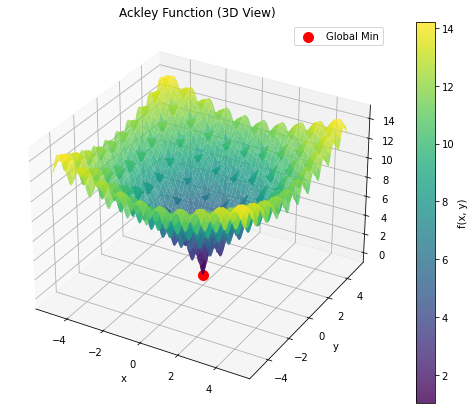

In [45]:
# Define Ackley function (vectorized)
def ackley(x, y):
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
    return term1 + term2 + 20 + np.e

# Generate data
x = y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(x, y)
Z = ackley(X, Y)

# Plot static 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
fig.colorbar(surf, label='f(x, y)')
ax.scatter(0, 0, 0, c='red', s=100, label='Global Min')
ax.set_title("Ackley Function (3D View)")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()
plt.close()

------
Let see how our algorithm perform this task !

In [46]:
# Vector-compatible Ackley function
def ackley_pso(position):
    x, y = position[0], position[1]
    term1 = -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(2*np.pi*x) + np.cos(2*np.pi*y)))
    return term1 + term2 + 20 + np.e

# PSO fitness (maximization)
def pso_fitness(position):
    return -ackley_pso(position)  

# Initialize particles
n_particles = 30
dimensions = 2
bounds = np.array([[-5, 5], [-5, 5]]) 

particles = [{
    'position': np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=dimensions),
    'velocity': np.zeros(dimensions)
} for _ in range(n_particles)]

# Initialize velocities (optional, if not part of particles)
velocities = np.zeros((n_particles, dimensions))

# Run PSO
pso = PSO(particles, velocities, bounds, pso_fitness, w=0.7, c_1=1.5, c_2=1.5, max_iter=50)

# Optimization loop
while pso.iter < pso.max_iter:
    pso.next_step()

    # Print results for each iteration
    print(f"Iter n.{pso.iter} | Global Best {pso.gbest_fitness}")
    
    # Check algo final result
    if pso.iter == pso.max_iter:
        print('\n')
        print(f"The final result is: {-pso.gbest_fitness:4f}")

Iter n.1 | Global Best -3.26636564904441
Iter n.2 | Global Best -2.7570966902999747
Iter n.3 | Global Best -1.459084832483026
Iter n.4 | Global Best -1.459084832483026
Iter n.5 | Global Best -1.459084832483026
Iter n.6 | Global Best -0.8080283163061108
Iter n.7 | Global Best -0.8080283163061108
Iter n.8 | Global Best -0.8080283163061108
Iter n.9 | Global Best -0.09318322453879135
Iter n.10 | Global Best -0.09318322453879135
Iter n.11 | Global Best -0.09318322453879135
Iter n.12 | Global Best -0.09318322453879135
Iter n.13 | Global Best -0.09318322453879135
Iter n.14 | Global Best -0.06150483531321216
Iter n.15 | Global Best -0.06150483531321216
Iter n.16 | Global Best -0.033268098851988004
Iter n.17 | Global Best -0.033268098851988004
Iter n.18 | Global Best -0.033268098851988004
Iter n.19 | Global Best -0.033268098851988004
Iter n.20 | Global Best -0.033268098851988004
Iter n.21 | Global Best -0.033268098851988004
Iter n.22 | Global Best -0.033268098851988004
Iter n.23 | Global Best -

### Visualize results

1. Thanks to a 2D GIF in order to show particles movement over time
2. Thanks to a simple line graph to show how global best fiteness evolve over time

In [47]:
def gen_2D_gif(pso):
    """
    Utility function to plot a 2D GIF to show particles movement over time.
    """
    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 7), facecolor='white')  

    # Ackley surface
    x = y = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x, y)
    Z = ackley(X, Y)
    ax.contourf(X, Y, Z, levels=50, cmap='viridis')
    scat = ax.scatter([], [], c='red', s=30)

    iteration_text = ax.text(0.02, 0.95, '', transform=ax.transAxes,
                            fontsize=12, color='white', bbox=dict(facecolor='black', alpha=0.6))

    # Init function
    def init():
        scat.set_offsets(np.empty((0, 2)))
        return scat,

    def update(frame):
        positions = np.atleast_2d(pso.pos_history[frame])  # ensures shape (N, 2)
        scat.set_offsets(positions)
        iteration_text.set_text(f'Iteration: {frame+1}')
        return scat,

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(pso.pos_history),
                                init_func=init, blit=True)

    # Save as gif
    ani.save("pso_2d.gif", writer='pillow', fps=10)
    plt.close()
    # Display the GIF in Jupyter
    display(Image(filename='pso_2d.gif'))


def gen_line_plot(pso):
    """ 
    Utility function to plot a line graph to show global best fit over iterations.
    """
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(pso.gbest_fit_history, label='Global Best Fitness', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.title('Global Best Fitness Over Iterations')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.close()

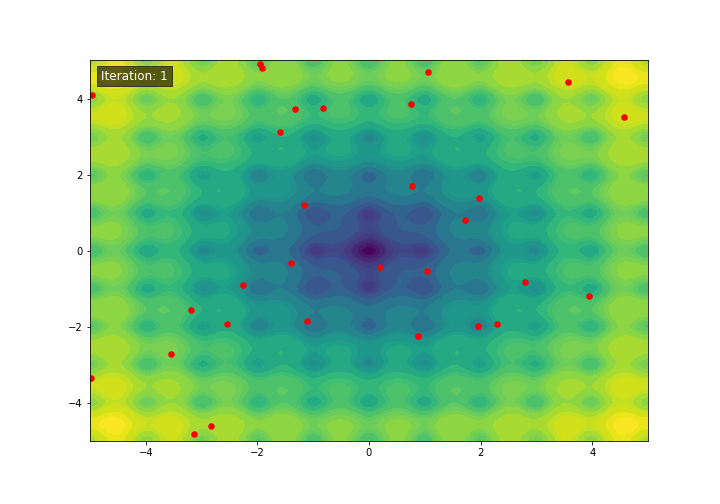

In [48]:
gen_2D_gif(pso)

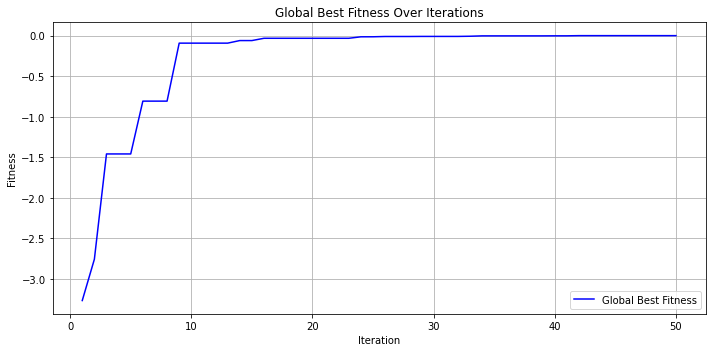

In [49]:
gen_line_plot(pso)

-------

## Rastrigin Function Test

We now test the optimizer using the **Rastrigin Function**, another classic benchmark in global optimization. It is particularly challenging due to its large number of local minima.

$$
f(x, y) = 20 + (x^2 - 10 \cos(2\pi x)) + (y^2 - 10 \cos(2\pi y))
$$

**Rastrigin Function (2D) Properties:**

- **Global minimum:** $f(0, 0) = 0$
- **Search domain:** $x, y \in [-5.12, 5.12]$
- **Challenge:** Highly multimodal landscape due to the cosine terms, which introduce frequent and deceptive local minima.

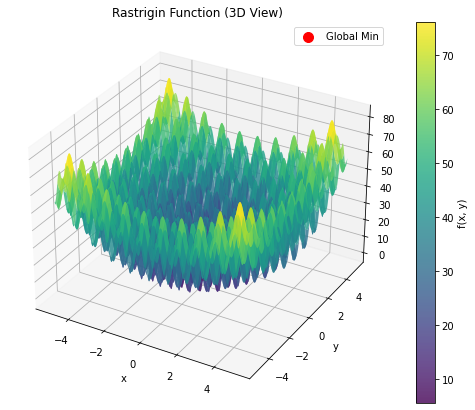

In [50]:
# Define Rastrigin function (vectorized)
def rastrigin(x, y):
    return 20 + (x**2 - 10 * np.cos(2 * np.pi * x)) + (y**2 - 10 * np.cos(2 * np.pi * y))

# Generate data
x = y = np.linspace(-5.12, 5.12, 500)
X, Y = np.meshgrid(x, y)
Z = rastrigin(X, Y)

# Plot static 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
fig.colorbar(surf, label='f(x, y)')
ax.scatter(0, 0, rastrigin(0, 0), c='red', s=100, label='Global Min')
ax.set_title("Rastrigin Function (3D View)")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

In [55]:
# Vector-compatible Rastrigin function 
def rastrigin(position):
    x, y = position[0], position[1]
    return 20 + (x**2 - 10 * np.cos(2 * np.pi * x)) + (y**2 - 10 * np.cos(2 * np.pi * y))

# PSO fitness (maximization)
def pso_fitness(position):
    return -rastrigin(position)  

# Initialize particles
n_particles = 30
dimensions = 2
bounds = np.array([[-5.12, 5.12], [-5.12, 5.12]]) 

particles = [{
    'position': np.random.uniform(low=bounds[:, 0], high=bounds[:, 1], size=dimensions),
    'velocity': np.zeros(dimensions)
} for _ in range(n_particles)]

# Initialize velocities (optional, if not part of particles)
velocities = np.zeros((n_particles, dimensions))

# Run PSO
pso = PSO(particles, velocities, bounds, pso_fitness, w=0.7, c_1=1.5, c_2=1.5, max_iter=50)

# Optimization loop
while pso.iter < pso.max_iter:
    pso.next_step()

    # Print results for each iteration
    print(f"Iter n.{pso.iter} | Global Best {pso.gbest_fitness}")
    
    # Check algo final result
    if pso.iter == pso.max_iter:
        print('\n')
        print(f"The final result is: {-pso.gbest_fitness:4f}")

Iter n.1 | Global Best -16.32892870354121
Iter n.2 | Global Best -3.724210283763041
Iter n.3 | Global Best -3.724210283763041
Iter n.4 | Global Best -3.64806512920296
Iter n.5 | Global Best -3.64806512920296
Iter n.6 | Global Best -3.64806512920296
Iter n.7 | Global Best -1.0154903171433176
Iter n.8 | Global Best -1.0154903171433176
Iter n.9 | Global Best -1.0154903171433176
Iter n.10 | Global Best -1.0154903171433176
Iter n.11 | Global Best -1.0154903171433176
Iter n.12 | Global Best -1.0154903171433176
Iter n.13 | Global Best -0.6226765532720577
Iter n.14 | Global Best -0.23085996943020248
Iter n.15 | Global Best -0.23085996943020248
Iter n.16 | Global Best -0.23085996943020248
Iter n.17 | Global Best -0.23085996943020248
Iter n.18 | Global Best -0.23085996943020248
Iter n.19 | Global Best -0.23085996943020248
Iter n.20 | Global Best -0.23085996943020248
Iter n.21 | Global Best -0.23085996943020248
Iter n.22 | Global Best -0.23085996943020248
Iter n.23 | Global Best -0.22048255050447

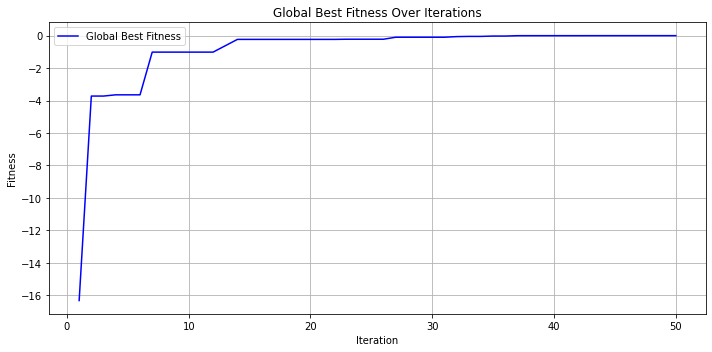

In [56]:
gen_line_plot(pso)

----------------

# PSO for Portofolio Optimization

Let now finally implement the PSO algorithm for a Portfolio Optimization task. We are going to use real market data for roughly 20 assets.

In [58]:
# IMPORT DATA 
try:
    df = pd.read_csv('amc­2.csv', parse_dates=['date'],dayfirst=True,index_col='date')
    print('Data successfull imported')
    # print(df.head())
except FileNotFoundError:
    print("Error: File 'amc2.csv' not found. Check the file path!")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Data successfull imported


In [59]:
df

,BMADM64 Index,BLOK US Equity,QYLD US Equity,TDIV US Equity,KCE US Equity,IAI US Equity,MTFF47 IT Equity,MHCD CN Equity,PRN US Equity,XLI US Equity,...,HGY CN Equity,UTES US Equity,IDU US Equity,STXPRO SJ Equity,RUD CN Equity,DXF CN Equity,EMB US Equity,SDVY US Equity,UVXY US Equity,VIXY US Equity
date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,1380.608,19.01,23.735,43.7700,59.7792,69.3400,#NAME?,10.59,69.0181,83.01,...,10.18,40.5193,80.015,1471.0,12.503333,28.82,114.70,21.7828,6065.00,239.00
2020-01-03,1377.404,18.85,23.710,43.3000,59.2963,68.9500,2869,10.58,69.1044,82.85,...,10.32,40.6870,80.080,1461.0,12.470000,28.76,114.41,21.6577,6505.00,251.00
2020-01-06,1377.821,19.00,23.750,43.1900,59.3900,69.1000,2890,10.57,68.9174,82.88,...,10.40,40.6700,80.195,1445.0,12.436667,28.72,114.18,21.6600,6410.00,248.00
2020-01-07,1375.738,19.12,23.770,43.1900,59.4907,69.2812,2894,10.63,69.1300,82.71,...,10.36,40.4948,80.090,1449.0,12.453333,28.73,114.36,21.6100,6365.00,247.00
2020-01-08,1376.228,19.27,23.820,43.4126,59.8510,69.6146,2896,10.69,69.1500,82.99,...,10.36,40.5156,80.075,1436.0,12.560000,29.05,114.66,21.6259,6185.00,242.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14,1889.450,39.77,18.230,82.1300,131.1900,134.8400,4451,NaN,159.0100,139.25,...,NaN,64.5500,101.740,1167.0,NaN,NaN,92.25,37.0200,26.69,12.89
2024-10-15,1883.704,39.29,18.220,80.5500,132.1800,135.9000,4463,12.24,157.7700,138.18,...,11.57,64.2000,102.160,1173.0,24.653333,NaN,92.50,36.8400,28.00,13.29
2024-10-16,1886.303,40.19,18.230,80.6300,133.9100,137.9800,4463,12.26,161.8200,139.25,...,11.62,65.9100,103.940,1178.0,24.790000,44.11,92.73,37.2900,27.52,13.17


In [60]:
# Check for N/A values and drop them 
df.isna().sum()

BMADM64 Index         0
BLOK US Equity       41
QYLD US Equity       41
TDIV US Equity       41
KCE US Equity        41
IAI US Equity        41
MTFF47 IT Equity     73
MHCD CN Equity       58
PRN US Equity        41
XLI US Equity        41
ITB US Equity        41
PAVE US Equity       41
XHB US Equity        41
VYM US Equity        41
XTL US Equity        41
XLC US Equity        41
ENFR US Equity       41
EINC US Equity       41
HGY CN Equity        44
UTES US Equity       41
IDU US Equity        41
STXPRO SJ Equity     48
RUD CN Equity        44
DXF CN Equity       343
EMB US Equity        41
SDVY US Equity       56
UVXY US Equity       41
VIXY US Equity       41
dtype: int64

- Drop DXF CN equity, MHCD CN Equity, MTFF47 IT Equity, STXPRO SJ Equity, RUD CN Equity, SDVY US Equity  --> too missing N/A values
- Other equity have the same number of N/A since "no market day" are present --> remove these rows

In [175]:
prices = df.copy()
columns_to_drop = ['MTFF47 IT Equity', 
                   'MHCD CN Equity',
                   'HGY CN Equity', 
                   'STXPRO SJ Equity',
                   'RUD CN Equity',
                   'DXF CN Equity',
                   'SDVY US Equity',
                   'BMADM64 Index',
                   'BLOK US Equity',
                   'QYLD US Equity',
                   'TDIV US Equity',
                   'KCE US Equity',
                   'IAI US Equity']
prices = prices.drop(columns_to_drop, axis='columns')
prices

,PRN US Equity,XLI US Equity,ITB US Equity,PAVE US Equity,XHB US Equity,VYM US Equity,XTL US Equity,XLC US Equity,ENFR US Equity,EINC US Equity,UTES US Equity,IDU US Equity,EMB US Equity,UVXY US Equity,VIXY US Equity
date,,,,,,,,,,,,,,,
2020-01-02,69.0181,83.01,44.31,17.7800,45.65,93.97,70.3274,54.26,20.8195,55.044955,40.5193,80.015,114.70,6065.00,239.00
2020-01-03,69.1044,82.85,44.44,17.7350,45.41,93.23,69.9485,53.91,20.9700,55.380055,40.6870,80.080,114.41,6505.00,251.00
2020-01-06,68.9174,82.88,44.84,17.6861,45.75,93.28,70.0300,54.63,21.1600,56.175056,40.6700,80.195,114.18,6410.00,248.00
2020-01-07,69.1300,82.71,44.73,17.6600,45.54,92.90,70.0959,54.70,21.1400,56.130056,40.4948,80.090,114.36,6365.00,247.00
2020-01-08,69.1500,82.99,45.15,17.7050,45.98,93.14,70.4200,55.09,20.9060,55.694756,40.5156,80.075,114.66,6185.00,242.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-14,159.0100,139.25,126.33,42.1600,123.67,130.96,101.2420,90.85,29.6300,89.308500,64.5500,101.740,92.25,26.69,12.89
2024-10-15,157.7700,138.18,127.16,41.9200,123.80,130.35,101.1900,91.05,29.3300,88.420000,64.2000,102.160,92.50,28.00,13.29
2024-10-16,161.8200,139.25,128.87,42.3600,125.25,131.31,103.2500,90.99,29.5500,89.232800,65.9100,103.940,92.73,27.52,13.17


- From the initial 28 assets we have now 15 assets

------------------

Let now calculate daily returns and print a summary of the results.

In [214]:
returns = prices.pct_change().dropna()
returns.describe()

/var/folders/zy/2fsj68lx24b53_1kz5hrf99m0000gn/T/ipykernel_57327/1668066822.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


,PRN US Equity,XLI US Equity,ITB US Equity,PAVE US Equity,XHB US Equity,VYM US Equity,XTL US Equity,XLC US Equity,ENFR US Equity,EINC US Equity,UTES US Equity,IDU US Equity,EMB US Equity,UVXY US Equity,VIXY US Equity
count,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000,1246.000000
mean,0.000819,0.000522,0.001113,0.000854,0.001021,0.000346,0.000443,0.000534,0.000474,0.000588,0.000484,0.000309,-0.000142,-0.001982,-0.001236
std,0.016577,0.014577,0.022420,0.017521,0.020386,0.012366,0.015890,0.015260,0.019272,0.020027,0.014147,0.014253,0.007975,0.071769,0.048747
min,-0.113179,-0.113441,-0.201923,-0.135843,-0.183859,-0.100578,-0.093889,-0.112795,-0.219592,-0.216623,-0.103551,-0.108664,-0.092160,-0.283795,-0.205151
25%,-0.007702,-0.005811,-0.009355,-0.007439,-0.008753,-0.004788,-0.008302,-0.006448,-0.007507,-0.007601,-0.006016,-0.006396,-0.003256,-0.039398,-0.026560
50%,0.000790,0.000568,0.000993,0.000989,0.000583,0.000457,0.000146,0.000453,0.000794,0.000747,0.000541,0.000475,0.000000,-0.011032,-0.007152
75%,0.009884,0.007357,0.012000,0.009745,0.011776,0.006037,0.009600,0.008319,0.008712,0.008996,0.007568,0.007046,0.003277,0.024105,0.015729
max,0.107940,0.126512,0.166529,0.129741,0.154531,0.090469,0.088021,0.089901,0.112805,0.175605,0.098826,0.121129,0.045961,0.583034,0.430511


Finally let calculate mean returns and cov_matrix in order to have the as np.array() for further calcualtions.

In [215]:
mean_returns = returns.mean().values
cov_matrix = returns.cov().values

print(mean_returns, '\n \n',cov_matrix )

[ 0.00081935  0.00052197  0.00111302  0.00085406  0.0010213   0.00034602
  0.00044347  0.00053397  0.00047435  0.00058765  0.00048409  0.000309
 -0.00014176 -0.00198235 -0.0012359 ] 
 
 [[ 2.74794447e-04  2.10138885e-04  2.85687079e-04  2.58808423e-04
   2.82607577e-04  1.64935950e-04  2.07016753e-04  1.74497661e-04
   1.95487421e-04  1.84709921e-04  1.38431777e-04  1.35700463e-04
   7.37701228e-05 -8.11099017e-04 -5.49702230e-04]
 [ 2.10138885e-04  2.12498801e-04  2.48101272e-04  2.42420437e-04
   2.46454144e-04  1.67879527e-04  1.75959426e-04  1.52985571e-04
   1.98920110e-04  1.84622850e-04  1.39289992e-04  1.44597505e-04
   6.75874298e-05 -6.76332198e-04 -4.58946444e-04]
 [ 2.85687079e-04  2.48101272e-04  5.02664673e-04  3.01500455e-04
   4.44650433e-04  1.90054209e-04  2.41610650e-04  2.12825095e-04
   2.30354488e-04  2.27496829e-04  1.68507421e-04  1.69359918e-04
   1.12146771e-04 -8.82199760e-04 -5.96723717e-04]
 [ 2.58808423e-04  2.42420437e-04  3.01500455e-04  3.06974955e-04
 

---------------------

Let now build a function to calcualte sharpe ratio of the portfolio

In [189]:

def portfolio_sharpe(weights):
    """
    Calcualte portofolio sharpe ratio given the weights.

    Parameters
    ----------
    weights (float): Asset allocation weights 

    Return
    ------
    sharpe (float): Portfolio sharpe ratio
    """

    risk_free = 0.04
    
    # # Weights normalization
    weights = weights / np.sum(weights) # Ensure weights sum to 1

    # Calculate portfolio return and volatility
    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Avoid division by zero in case of 0 volatility
    if port_volatility == 0:
        #raise ValueError('Portfolio have 0 volatility wth the following weights: ', weights)
        print(weights)
        return np.inf
    
    # Calculate sharpe
    sharpe = (port_return - risk_free) / port_volatility
    return sharpe # Since we want to maximize it


# PSO fitness (maximization)
def pso_fitness(position):
    return -portfolio_sharpe(position)  

# Initialize particles
n_particles = 100
dimensions = len(returns.columns)

# Bounds: weights in [-1, 1] in long/short portfolios. By default the bounds are for long only portfolio [0,1]
lower_bound = 0
upper_bound = 1

bounds = np.array([[lower_bound, upper_bound]] * dimensions) 

particles = [{
    'position': np.random.uniform(low=lower_bound, high=upper_bound, size=dimensions),
    'velocity': np.zeros(dimensions)
} for _ in range(n_particles)]

# Initialize velocities (optional, if not part of particles)
velocities = np.zeros((n_particles, dimensions))

# Run PSO
pso = PSO(particles, velocities, bounds, pso_fitness, w=0.7, c_1=1.5, c_2=1.5, max_iter=200)

# Optimization loop
while pso.iter < pso.max_iter:
    pso.next_step()

    # Print results for each iteration
    print(f"Iter n.{pso.iter} | Global Best {pso.gbest_fitness}")
    
    # Check algo final result
    if pso.iter == pso.max_iter:
        print('\n')

Iter n.1 | Global Best 5.354525897990541
Iter n.2 | Global Best 5.570760527372629
Iter n.3 | Global Best 5.9427519118207055
Iter n.4 | Global Best 6.000561586805487
Iter n.5 | Global Best 6.162304870102365
Iter n.6 | Global Best 6.335639413745095
Iter n.7 | Global Best 6.48720781192433
Iter n.8 | Global Best 6.911987900441228
Iter n.9 | Global Best 6.911987900441228
Iter n.10 | Global Best 6.911987900441228
Iter n.11 | Global Best 6.911987900441228
Iter n.12 | Global Best 6.911987900441228
Iter n.13 | Global Best 6.911987900441228
Iter n.14 | Global Best 6.937458277702543
Iter n.15 | Global Best 6.937458277702543
Iter n.16 | Global Best 6.942605398406843
Iter n.17 | Global Best 6.942605398406843
Iter n.18 | Global Best 6.942605398406843
Iter n.19 | Global Best 6.943756642448925
Iter n.20 | Global Best 6.943756642448925
Iter n.21 | Global Best 6.944968468492198
Iter n.22 | Global Best 6.944968468492198
Iter n.23 | Global Best 6.944968468492198
Iter n.24 | Global Best 6.945990134333272
I

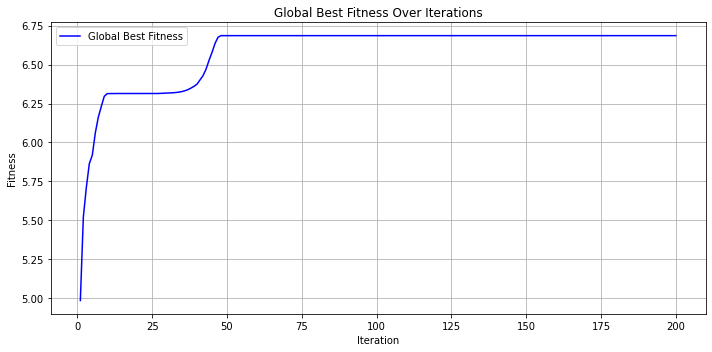

In [183]:
gen_line_plot(pso)

### SCIPY OPTIMIZE SLSQP VERSION 

In [194]:
from scipy.optimize import minimize

# Constraints: weights sum to 1
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = [(0, 1)] * len(mean_returns)
initial_guess = np.ones(len(mean_returns)) / len(mean_returns)

result = minimize(portfolio_sharpe, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

opt_weights = result.x
-portfolio_sharpe(opt_weights)

6.946714057021434

### GA VERSION

Follow an implementation of the GA algorithm. Let compare its performance with PSO. 

In [ ]:
def fitness_func(ga_instance, solution, solution_idx):
    risk_free_rate = 0.04

    weights = np.array(solution)
    
    # Ensure weights are positive and normalized (optional but recommended)
    weights = np.clip(weights, 0, 1)
    weights /= weights.sum()

    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    if port_volatility == 0:
        return 0  # Prevent division by zero

    sharpe_ratio = (port_return - risk_free_rate) / port_volatility
    return -sharpe_ratio

fitness_function = fitness_func

num_assets = returns.shape[1]

ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=4,
    fitness_func=fitness_function,
    sol_per_pop=8,
    num_genes=num_assets, 
    init_range_low=0,
    init_range_high=1,
    parent_selection_type="sss",
    keep_parents=1,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=10
)

ga_instance.run()

# Retrieve the best solution
best_solution, best_solution_fitness, best_match_idx = ga_instance.best_solution()

print("Best Solution Weights:", best_solution)
print("Best Sharpe Ratio:", best_solution_fitness)

15
Best Solution Weights: [ 0.1174325  -0.50721831 -0.39382965 -0.49475555 -0.21346691  1.90248844
  0.35859755  0.76307562 -0.12401038 -0.02558295 -1.27977124 -0.71820819
  3.51193832 -0.50747271  0.64899404]
Best Sharpe Ratio: 6.248656690671696


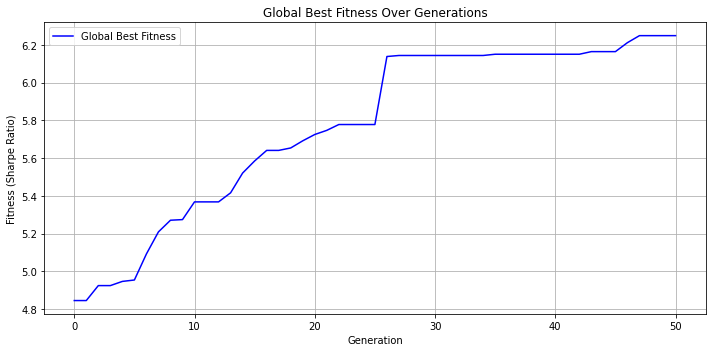

In [ ]:
# Plotting best solution fitness over generations
plt.figure(figsize=(10, 5))
plt.plot(ga_instance.best_solutions_fitness, label='Global Best Fitness', color='blue')
plt.xlabel('Generation')
plt.ylabel('Fitness (Sharpe Ratio)')
plt.title('Global Best Fitness Over Generations')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()